In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter



# Algorithms
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
# preproceessing
from abpred.Transformers import FeaturesInteractions, SkewTransformer, ZeroThreshold
#from abpred.stacking_models import StackingAveragedModels
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler

import joblib

In [3]:

#dataframe final
df_final = pd.read_csv("../../abpred_train_2020.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG',axis=1).columns
df_final.shape

(1796, 78)

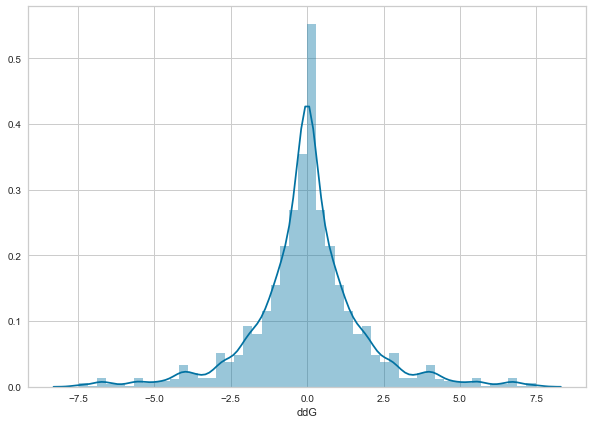

In [4]:
f, ax = plt.subplots(figsize=(10, 7))
sns.distplot(df_final['ddG'],bins=None);
#plt.savefig("Train15_balanced.svg",dpi=300,bbox_inches="tight")

## Binarizing for stratified split

In [5]:
bins = np.histogram_bin_edges(df_final['ddG'], bins='rice')
#bins = np.linspace(df_final['ddG'].min(), df_final['ddG'].max(), 37)
y_binned = np.digitize(df_final['ddG'],bins)



In [6]:

counts = Counter(y_binned)
counts

Counter({13: 486,
         17: 46,
         24: 9,
         14: 259,
         20: 24,
         16: 93,
         15: 145,
         12: 259,
         18: 35,
         11: 145,
         19: 18,
         21: 9,
         22: 10,
         10: 93,
         6: 24,
         9: 46,
         8: 35,
         26: 1,
         5: 9,
         25: 3,
         23: 3,
         7: 18,
         2: 9,
         4: 10,
         1: 4,
         3: 3})

In [7]:
# merge group 26 with 25
y_binned[np.where(y_binned==26)] = 25

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG',axis=1), df_final['ddG'],stratify=y_binned,
                                                    test_size=0.2, random_state=13)


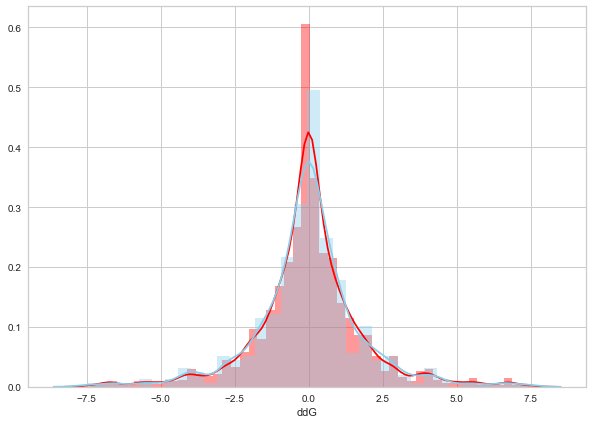

In [9]:
f, ax = plt.subplots(figsize=(10, 7))

sns.distplot(y_train, color="red", label="ddG_exp_train");
sns.distplot(y_test, color="skyblue", label="ddG_exp_test");

In [10]:
# join train data for Exploratory analisis of training data
train = X_train.join(y_train)


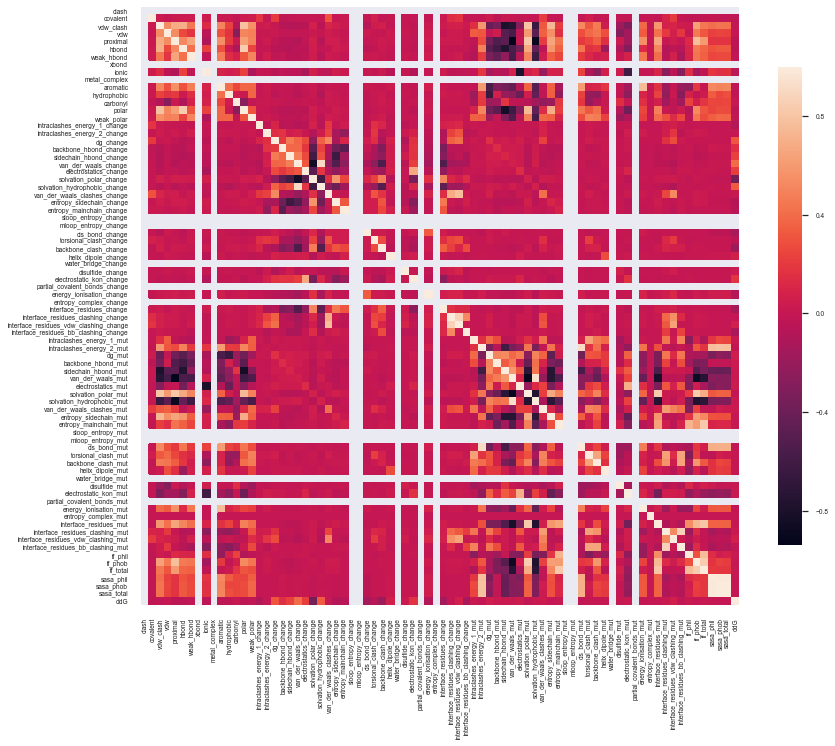

In [11]:
sns.set(font_scale=0.6)

#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, square=True,cbar_kws={"shrink": .8});
#plt.savefig("Train15_initCorr.png",dpi=300,bbox_inches="tight")

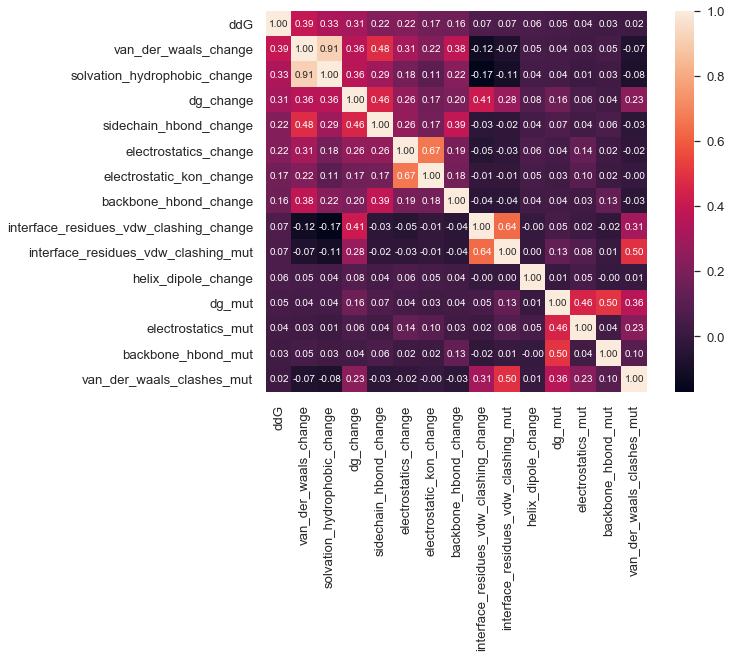

In [12]:
sns.set(font_scale=1.2)


#top 10. correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ddG')['ddG'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);
#plt.savefig("Train15_initCorrTOP15.png",dpi=300,bbox_inches="tight")

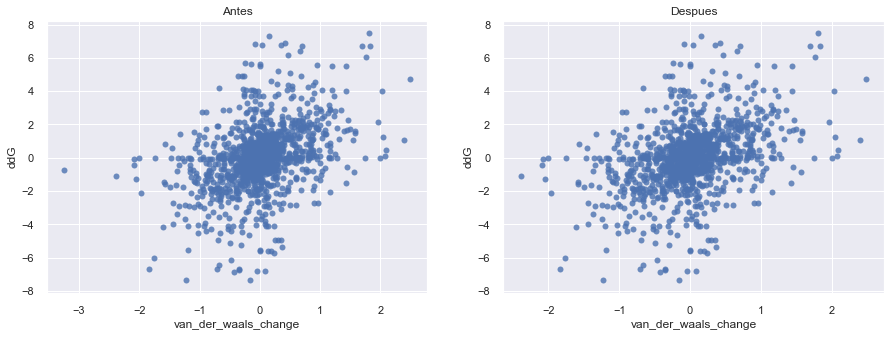

In [13]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG'], fit_reg=False).set_title("Antes")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['van_der_waals_change']<-3)].index)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG'], fit_reg=False).set_title("Despues")
#plt.savefig("Train15_outlierVDWchange.png",dpi=600,bbox_inches="tight")

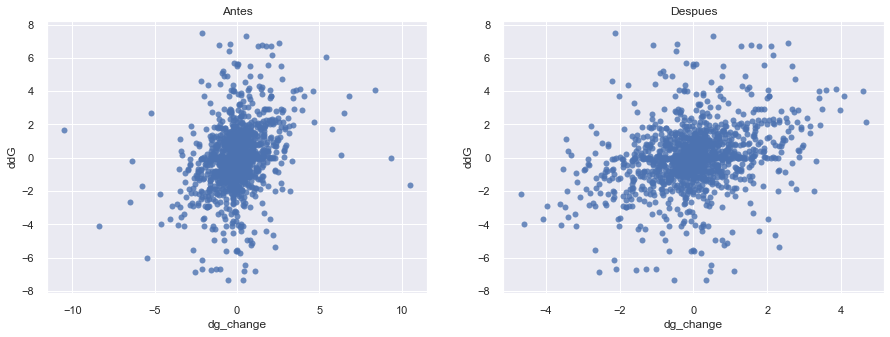

In [14]:
sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['dg_change'], y=train['ddG'], fit_reg=False).set_title("Antes")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['dg_change'].abs()>5)].index)
g = sns.regplot(x=train['dg_change'], y=train['ddG'], fit_reg=False).set_title("Despues")
#plt.savefig("Train15_outlierDgchange.png",dpi=600,bbox_inches="tight")

In [15]:
y_train = train['ddG']
X_train = train.drop('ddG',axis=1)

In [16]:
X_test.shape,X_train.shape

((360, 77), (1420, 77))

In [17]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [132]:
# #### Crossvalidation strategy

# In[6]:

def cv_results(cv_object):
    # scores
    rmse_train_cv = np.sqrt(-cv_object["train_neg_mean_squared_error"])
    rmse_test_cv = np.sqrt(-cv_object["test_neg_mean_squared_error"])
    r2_train_cv = cv_object["train_r2"]
    r2_test_cv = cv_object["test_r2"]

    print("RMSE train CV: {:.4f} ({:.4f})".format(rmse_train_cv.mean(), rmse_train_cv.std()))
    print("RMSE test CV: {:.4f} ({:.4f})".format(rmse_test_cv.mean(), rmse_test_cv.std()))
    print('DIFF RMSE {}\n'.format(rmse_test_cv.mean() - rmse_train_cv.mean()))

    print("r2 train CV: {:.4f} ({:.4f})".format(r2_train_cv.mean(), r2_train_cv.std()))
    print("r2 test CV: {:.4f} ({:.4f})".format(r2_test_cv.mean(), r2_test_cv.std()))
    print('DIFF RMSE {}\n'.format(r2_test_cv.mean() - r2_train_cv.mean()))


def test_results(fitted_estimator, Xtest, Ytest):
    y_test_pred = fitted_estimator.predict(Xtest)
    # y_train_pred = fitted_estimator.predict(Xtrain)

    print("RMSE test: {}".format(np.round(np.sqrt(mean_squared_error(Ytest, y_test_pred)), 2)))

    print('r2 test', r2_score(Ytest, y_test_pred))
    # print('r2 train',r2_score(Ytrain,y_train_pred))

    print("Pearson corr test {:f}".format(np.corrcoef(y_test_pred, Ytest.ravel())[0][1]))


# Validation function
n_folds = 10
def evaluating(model, Xtrain, Ytarget):
    # kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain)
    rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=["r2", "neg_mean_squared_error"],
                             cv=rkf, verbose=1, n_jobs=-1, return_train_score=True, return_estimator=True)
    return cvscore

def evaluating2(model, Xtrain, Ytarget):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain.values)
    # rkf = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=["r2", "neg_mean_squared_error"],
                             cv=kf, verbose=1, n_jobs=-1, return_train_score=True, return_estimator=True)
    return cvscore

In [69]:
# preprocess pipeline steps
# steps pipeline
interactions = FeaturesInteractions(features1=range(15), feature2=20)
variance = VarianceThreshold(threshold=0.)
skewness = SkewTransformer(threshold=0.5)
zeroth = ZeroThreshold(threshold=90.)


In [70]:
from vecstack import StackingTransformer,stacking
#https://github.com/vecxoz/vecstack/blob/master/examples/04_sklearn_api_regression_pipeline.ipynb

In [117]:
#lasso model
lasso = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      Lasso(alpha=0.0005,normalize=False,fit_intercept=True,random_state=1))
# svr polynomial kernel
svrP = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.2,gamma=0.4,kernel='poly'))

svrRBF = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      SVR(C=5,epsilon=0.5,gamma=0.7,kernel='rbf'))

gbt = make_pipeline(interactions,variance,skewness,zeroth,
                    GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=8, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=0.6,alpha=0.7))

xgb = make_pipeline(interactions,variance,skewness,zeroth,
                   XGBRegressor(colsample_bytree=0.6, gamma=0,
                             learning_rate=0.07, max_depth=8, 
                             min_child_weight=20, n_estimators=1000,
                             reg_alpha=0.000005, reg_lambda=100,
                             subsample=0.9,random_state =7, nthread=-1,objective='reg:squarederror'))

extra = make_pipeline(interactions,variance,skewness,zeroth,
                     ExtraTreesRegressor(n_estimators=100,max_depth=5,n_jobs=-1,random_state=13,min_samples_split=2))

In [118]:
estimators_L1 = [
    ('lasso', lasso),        
    ('gbt', gbt),        
    ('svrRBF', svrRBF),
    ('svrPoly', svrP),
]

In [119]:
stack = StackingTransformer(estimators=estimators_L1,   # base estimators
                            regression=True,            # regression task (if you need 
                                                        #     classification - set to False)
                            variant='A',                # oof for train set, predict test 
                                                        #     set in each fold and find mean
                            metric=mean_squared_error, # metric: callable
                            n_folds=10,                  # number of folds
                            shuffle=True,               # shuffle the data
                            random_state=13,             # ensure reproducibility
                            verbose=2)                  # print all info

In [120]:
#Initialize 2nd level estimator
#final_estimator = ExtraTreesRegressor(n_estimators=100,max_depth=5,n_jobs=-1,random_state=13,min_samples_split=2)
final_estimator = Lasso(alpha=0.0001,normalize=True,fit_intercept=False,random_state=1)


In [121]:
steps = [('stack', stack),
         ('final_estimator', final_estimator)]

# Init Pipeline
pipe = Pipeline(steps)
# Fit
pipe = pipe.fit(X_train, y_train)

task:         [regression]
metric:       [mean_squared_error]
variant:      [A]
n_estimators: [4]

estimator  0: [lasso: Pipeline]
    fold  0:  [2.62888343]
    fold  1:  [1.89740932]
    fold  2:  [2.93400195]
    fold  3:  [2.02907814]
    fold  4:  [2.98986228]
    fold  5:  [2.37088640]
    fold  6:  [3.13607708]
    fold  7:  [3.55792428]
    fold  8:  [2.62500987]
    fold  9:  [1.89431074]
    ----
    MEAN:     [2.60634435] + [0.53288653]

estimator  1: [gbt: Pipeline]
    fold  0:  [2.52528937]
    fold  1:  [1.68554433]
    fold  2:  [2.30894551]
    fold  3:  [2.01631441]
    fold  4:  [3.02789362]
    fold  5:  [2.24138001]
    fold  6:  [2.95165544]
    fold  7:  [2.96683400]
    fold  8:  [3.03663021]
    fold  9:  [1.98838663]
    ----
    MEAN:     [2.47488735] + [0.47384887]

estimator  2: [svrRBF: Pipeline]
    fold  0:  [2.47360952]
    fold  1:  [1.72497354]
    fold  2:  [2.65780945]
    fold  3:  [1.82366456]
    fold  4:  [3.05199270]
    fold  5:  [2.10013057]


In [135]:
eva_result = evaluating2(pipe,X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.7min finished


In [137]:
cv_results(eva_result)

RMSE train CV: 1.5307 (0.0160)
RMSE test CV: 1.5167 (0.1282)
DIFF RMSE -0.014022396451183416

r2 train CV: 0.2880 (0.0119)
r2 test CV: 0.2825 (0.0695)
DIFF RMSE -0.005462226431905026



In [125]:
# Final prediction score
print('Final prediction score using Pipeline:')
# # Final prediction score
pipe.set_params(stack__verbose=0)
test_results(pipe,X_test,y_test)

Final prediction score using Pipeline:
RMSE test: 1.43
r2 test 0.3941952442974278
Pearson corr test 0.637993


In [ ]:
Final prediction score using Pipeline:
RMSE test: 1.45
r2 test 0.3823413835134283
Pearson corr test 0.627855

In [126]:
# Save Pipeline
_ = joblib.dump(pipe, 'stack_lasso-lasso-gbt-svrRBF-svrPoly-2020.pkl')

# Model evaluation plots

In [127]:
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

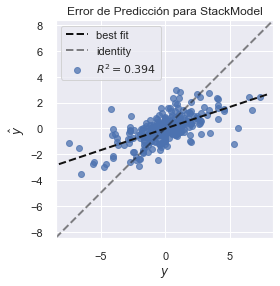

In [128]:
perror = PredictionError(pipe, title='Error de Predicción para StackModel')

perror.fit(X_train.values, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test.values, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()

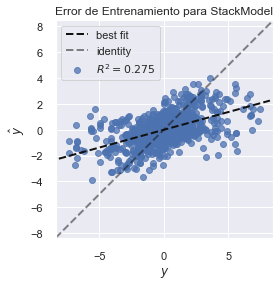

In [129]:
perror = PredictionError(pipe, title='Error de Entrenamiento para StackModel')

perror.fit(X_train.values, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_train.values, y_train.values.ravel())  # Evaluate the model on the test data

perror.finalize()
#plt.savefig("GBT_TrainingError_train15.png",dpi=300,bbox_inches="tight")

Text(0, 0.5, 'Residuos')

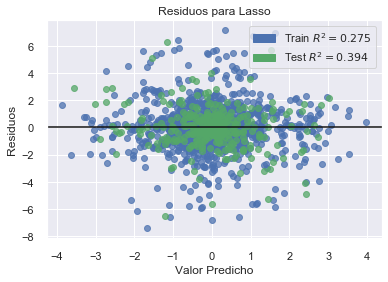

In [130]:
visualizer = ResidualsPlot(pipe,title='Residuos para Lasso',hist=False)

visualizer.fit(X_train.values, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test.values, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

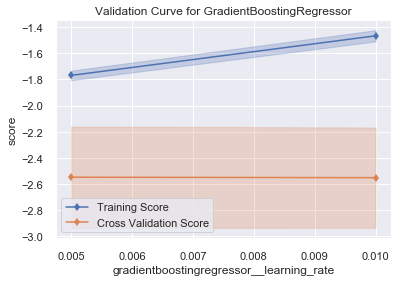

In [124]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#2)
pipeline1 = make_pipeline(interactions,variance,skewness,zeroth,
                      GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01,
                                   max_depth=3, max_features=None,
                                   min_samples_leaf=1, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=1,alpha=0.9))

# Extract the instances and target
viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="gradientboostingregressor__learning_rate",
    param_range=[0.005,0.01], cv=10, scoring="neg_mean_squared_error"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train.values, y_train.values)
viz.poof()

In [115]:
GradientBoostingRegressor?

In [114]:
np.sqrt(-viz.test_scores_mean_),np.sqrt(viz.test_scores_std_),np.sqrt(-viz.train_scores_mean_),

(array([1.55518557, 1.54541069, 1.54164995, 1.54021195]),
 array([0.65828384, 0.63391196, 0.62772039, 0.62575058]),
 array([1.35535365, 1.24223691, 1.19531894, 1.1537983 ]))

In [67]:
np.sqrt(-viz.test_scores_mean_),np.sqrt(viz.test_scores_std_),np.sqrt(-viz.train_scores_mean_),

(array([1.60830225, 1.60591848, 1.60247956, 1.60065132, 1.59861372]),
 array([0.59132508, 0.59370854, 0.61576116, 0.64526548, 0.65636424]),
 array([1.51241258, 1.51447181, 1.5250123 , 1.54247801, 1.55545154]))

In [22]:
from sklearn.metrics import SCORERS
SCORERS

{'explained_variance': make_scorer(explained_variance_score),
 'r2': make_scorer(r2_score),
 'max_error': make_scorer(max_error, greater_is_better=False),
 'neg_median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'neg_mean_squared_log_error': make_scorer(mean_squared_log_error, greater_is_better=False),
 'accuracy': make_scorer(accuracy_score),
 'roc_auc': make_scorer(roc_auc_score, needs_threshold=True),
 'balanced_accuracy': make_scorer(balanced_accuracy_score),
 'average_precision': make_scorer(average_precision_score, needs_threshold=True),
 'neg_log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True),
 'brier_score_loss': make_scorer(brier_score_loss, greater_is_better=False, needs_proba=True),
 'adjusted_rand_score': make_scorer(adjusted_rand_score),
 'homog